In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
np.random.seed(42)

In [3]:
project_dir = 'D:\\Heart_Disease_Project'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(os.path.join(project_dir, 'notebooks'), exist_ok=True)
os.makedirs(os.path.join(project_dir, 'results'), exist_ok=True)

In [4]:
cleaned_data_path = os.path.join(project_dir, 'data', 'heart_disease_cleaned.csv')
df = pd.read_csv(cleaned_data_path)
X = df.drop('target',axis=1)
y = df['target']
X = X.astype(float)

In [5]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X,y)
rf_importance = rf.feature_importances_
rf_scores_df = pd.DataFrame({'Feature':X.columns, 'RF_importance': rf_importance} )
rf_scores_df = rf_scores_df.sort_values(by='RF_importance', ascending=False)

In [6]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X,y)
xgb_importance = xgb_model.feature_importances_
xgb_scores_df = pd.DataFrame({'Feature':X.columns, 'XGB_importance': xgb_importance})
xgb_scores_df = xgb_scores_df.sort_values(by='XGB_importance', ascending=False)

d:\Heart_Disease_Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:19:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
importance_df = rf_scores_df.merge(xgb_scores_df, on='Feature')
importance_df['Average_importance'] = (importance_df['RF_importance'] + importance_df['XGB_importance']) /2
importance_df = importance_df.sort_values(by='Average_importance', ascending=False)
print('Feature Importance Ranking (Average of RF and XGBoost):\n', importance_df)

Feature Importance Ranking (Average of RF and XGBoost):
       Feature  RF_importance  XGB_importance  Average_importance
6        cp_4       0.058923        0.178133            0.118528
0     thalach       0.145161        0.040518            0.092840
5    thal_7.0       0.060592        0.111019            0.085805
1     oldpeak       0.119441        0.045579            0.082510
2         age       0.114960        0.036678            0.075819
3        chol       0.110535        0.029226            0.069881
4    trestbps       0.096552        0.023814            0.060183
18    slope_3       0.008491        0.110085            0.059288
9      ca_1.0       0.034681        0.066373            0.050527
11     ca_2.0       0.031061        0.059842            0.045451
7     exang_1       0.047135        0.039136            0.043136
13     ca_3.0       0.020094        0.054655            0.037375
10      sex_1       0.032970        0.041722            0.037346
8     slope_2       0.034934     

In [10]:
rf_for_rfe = RandomForestClassifier(n_estimators=100,random_state=42)
rfe = RFE(estimator=rf_for_rfe, n_features_to_select=10, step=1)
rfe.fit(X,y)
rfe_selected_features = X.columns[rfe.support_].to_list()
print(f'Features selected by RFE: {rfe_selected_features}')

Features selected by RFE: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'cp_4', 'exang_1', 'slope_2', 'ca_1.0', 'thal_7.0']


In [12]:
X_chi = X-X.min()
chi_selector = SelectKBest(score_func=chi2, k=10)
chi_selector.fit(X_chi,y)
chi_scores = pd.DataFrame({'Feature':X.columns, 'Chi2_score': chi_selector.scores_})
chi_scores = chi_scores.sort_values(by='Chi2_score', ascending=False)
chi_selected_features = X.columns[chi_selector.get_support()].tolist()
print(f'Features selected by Chi-Square Test: {chi_selected_features}')

Features selected by Chi-Square Test: ['thalach', 'oldpeak', 'cp_2', 'cp_3', 'cp_4', 'exang_1', 'slope_2', 'ca_2.0', 'ca_3.0', 'thal_7.0']


In [13]:
selected_features = list(set(rfe_selected_features) & set(chi_selected_features))
if len(selected_features) < 5:
    selected_features = rfe_selected_features[:5]
print(f'Final selected features (intersection or top 5 RFE): {selected_features}')

Final selected features (intersection or top 5 RFE): ['thalach', 'slope_2', 'thal_7.0', 'cp_4', 'oldpeak', 'exang_1']


In [14]:
X_reduced = X[selected_features]
reduced_df = pd.concat([X_reduced,y], axis=1)

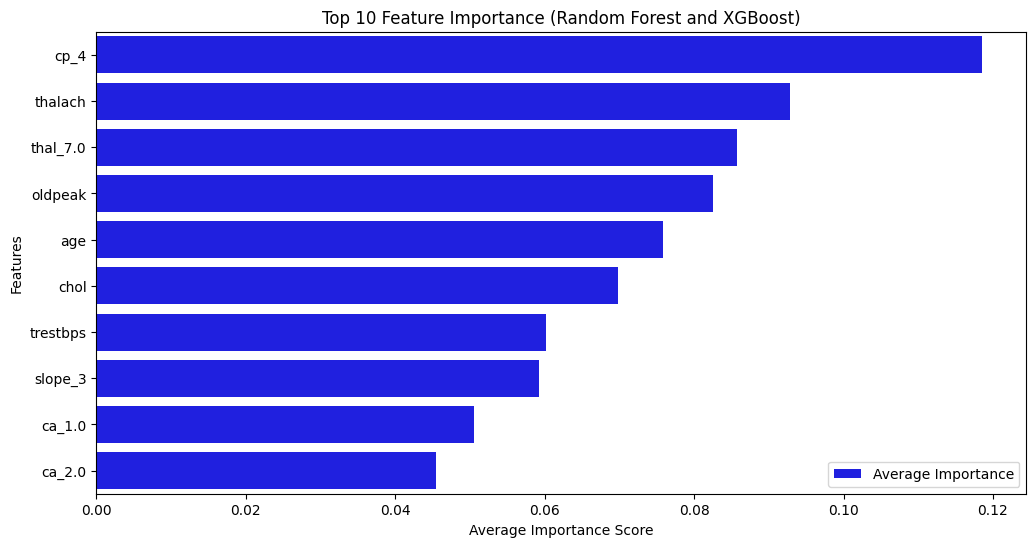

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data = importance_df.head(10), x = 'Average_importance', y = 'Feature', color = 'blue', label = 'Average Importance')
plt.title('Top 10 Feature Importance (Random Forest and XGBoost)')
plt.xlabel('Average Importance Score')
plt.ylabel('Features')
plt.legend()
plt.savefig(os.path.join(project_dir, 'results', 'feature_importance_plot.png'))
plt.show()

In [16]:
reduced_output_path = os.path.join(project_dir, 'data', 'heart_disease_reduced.csv')
reduced_df.to_csv(reduced_output_path, index=False)
print(f"Reduced dataset saved to {reduced_output_path}")

Reduced dataset saved to D:\Heart_Disease_Project\data\heart_disease_reduced.csv
